In [18]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch, helpers
import requests
from IPython.display import JSON
import numpy as np
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import math
from thefuzz import fuzz, process
import re

In [2]:
es = Elasticsearch()

In [3]:
# open a file, where you stored the pickled data
file = open('dataset_full.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [4]:
len(data["p"])

101773

In [5]:
len(data["n"])

41596

In [6]:
data["p"][0]

{'Authors': 'Jaramillo-Ayerbe F., Berrío-Muñoz J.',
 'Title': 'Ivermectin for crusted Norwegian scabies induced by use of topical steroids',
 'Year': 1998,
 'Source title': 'Archives of Dermatology',
 'DOI': '10.1001/archderm.134.2.143'}

In [7]:
data["n"][0]

{'Authors': 'Flórez G.A.D., Mombello E.E., Voss S.',
 'Title': 'Novel technique for the calculation of eddy current losses and Lorentz forces in foil winding transformers',
 'Year': 2017,
 'Source title': 'International Journal of Applied Electromagnetics and Mechanics',
 'DOI': '10..3233/JAE-160144'}

In [40]:
scopus = []
for i in data["p"][0:3000]:
    scopus.append((i,True))
for i in data["n"][0:3000]:
    scopus.append((i,False))

In [9]:
es_index = "openalex_test"


In [10]:
def get_oa_doi(es_reg):
    for i in es_reg["_source"]['external_ids']:
        if i['source'] == "doi":
            return i["id"]


def get_oa_doi(es_reg):
    return es_reg["_source"]['doi']


In [11]:
def search(Title, Authors, Source, Year, punto_de_corte = 0):
    """
    Definir el valor mínimo del _score que deseas
    Puedes ajustar este valor según tus necesidades

    """
    if not isinstance(Title, str):
        Title = ""
    if not isinstance(Source, str):
        Source = ""
        
        
    body = {
        "query": {
            "bool": {
                "should": [
                    { "match": { "title":  Title }},
                    { "match": { "authorships.author.display_name": Authors }},
                    { "match": { "host_venue.display_name":  Source}},
                    { "match": { "publication_year": Year }}
                ]
            }
        },
        "size": 10
    }
    
    res = es.search(index=es_index, **body)
    hits = []
    
    for i in res["hits"]["hits"]:
        if i["_score"] >= punto_de_corte:
            hits.append(i)
    res["hits"]["hits"] = hits
    return  res

In [34]:
%%time

def es_similarity(rec,th = 0):
    res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],th)
    if len(res["hits"]["hits"]) > 1:
        oa_doi = get_oa_doi(res["hits"]["hits"][0]).replace("https://doi.org/","").lower()
        sc_doi = rec["DOI"].lower()
        if oa_doi == sc_doi:
            return (res["hits"]["hits"][0],True)
        else:
            return (res["hits"]["hits"][0],False)

np.random.shuffle(scopus) #shuffle is inplace
th=0
results = Parallel(n_jobs=15,backend='threading',verbose=2)(delayed(es_similarity)(rec[0],th) for rec in scopus)


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:    1.2s
[Parallel(n_jobs=15)]: Done 335 tasks      | elapsed:    2.1s
[Parallel(n_jobs=15)]: Done 618 tasks      | elapsed:    3.9s
[Parallel(n_jobs=15)]: Done 983 tasks      | elapsed:    6.4s
[Parallel(n_jobs=15)]: Done 1428 tasks      | elapsed:    8.8s
[Parallel(n_jobs=15)]: Done 1955 tasks      | elapsed:   18.5s
[Parallel(n_jobs=15)]: Done 2562 tasks      | elapsed:   22.0s
[Parallel(n_jobs=15)]: Done 3251 tasks      | elapsed:   33.5s
[Parallel(n_jobs=15)]: Done 4020 tasks      | elapsed:   37.7s
[Parallel(n_jobs=15)]: Done 4871 tasks      | elapsed:   48.6s
[Parallel(n_jobs=15)]: Done 5802 tasks      | elapsed:   54.2s


CPU times: user 57.8 s, sys: 3.84 s, total: 1min 1s
Wall time: 1min 1s


[Parallel(n_jobs=15)]: Done 6000 out of 6000 | elapsed:  1.0min finished


In [35]:
results.count(None)

0

In [36]:
len(results)

6000

In [37]:
#>tp, tn, fp, fn
actual  = [i[1] for i in scopus]
predicted = [i[1] for i in results]


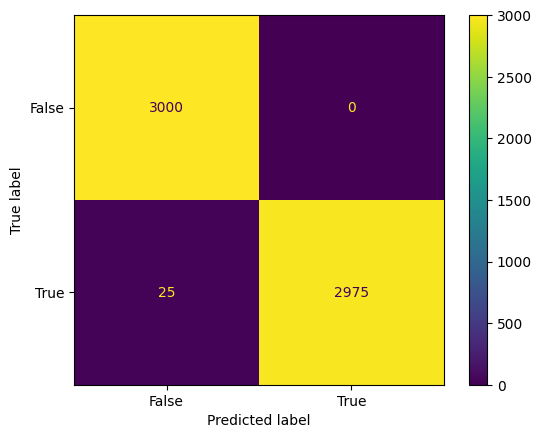

In [38]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [39]:
acc = metrics.accuracy_score(actual,predicted)
pre = metrics.precision_score(actual,predicted)
rec = metrics.recall_score(actual,predicted)
f1  = metrics.f1_score(actual,predicted)

print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {pre:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1        = {f1:.4f}")


Accuracy  = 0.9958
Precision = 1.0000
Recall    = 0.9917
F1        = 0.9958


In [19]:
def parse_string(text):
    text = unidecode(text.lower())
    text = re.sub( r'[\$_\^]','', re.sub(r'\\\w+','',text ))
    return str(text)

def __colav_similarity(title1,title2,journal1,journal2,year1,year2, ratio_thold=90, partial_thold=95,low_thold=80,verbose=0):

    label = False
    
    #Se revisa si los años y las revistas coinciden
    journal_check = False
    if journal1 and journal2:
        if fuzz.partial_ratio(unidecode(journal1.lower()),unidecode(journal2.lower()))>ratio_thold:
            journal_check=True
    year_check=False
    if year1 and year2:
        if year1==year2:
            year_check = True
    
    length_check=False
    if len(title1.split())>3 and len(title2.split())>3:
        length_check=True
        
    #Si son pocas palabras y no hay por lo menos revista o año para revisar, se descarta de uan vez
    if length_check == False and (journal_check == False or year_check == False):
        return label
    
    if verbose==5:
        if journal_check: print("Journals are the same")
        if year_check: print("Years are the same")
    
    ratio = fuzz.ratio(title1, title2)
    if verbose==5: print("Initial ratio: ",ratio)
    if ratio > ratio_thold and length_check: #Comparación "directa"
        label = True
    if label == False:
        #Comparaciones cuando el título viene en varios idiomas
        title1_list=title1.split("[")
        title2_list=title2.split("[")
        if min([len(item) for item in title1_list]) > 10 and min([len(item) for item in title2_list]) > 10:
            for title in title1_list:
                tmp_title,ratio=process.extractOne(title,title2_list,scorer=fuzz.ratio)
                if ratio > ratio_thold:
                    label=True
                    break
            #if verbose==5: print("ratio over list: ",ratio)
            if label==False:
                for title in title1_list:
                    tmp_title,ratio=process.extractOne(title,title2_list,scorer=fuzz.partial_ratio)
                    if ratio > partial_thold:
                        label=True
                        break
                    elif ratio > low_thold:
                        if journal_check and year_check:
                            label=True
                            break
                #if verbose==5: print("partial ratio over list: ",ratio)
    
    #Partial ratio section
    if label == False:
        ratio = fuzz.partial_ratio(title1, title2) #Cuando la comparación "directa" falla, relajamos el scorer
        #if verbose==5: print("partial ratio: ",ratio)
                
        if ratio > partial_thold and length_check: #si el score supera el umbral (que debería ser mayor al umbral del ratio)
            label=True
        elif ratio > low_thold: #si no lo supera pero sigue siendo un valor alto, revisa el año y la revista
            if journal_check and year_check:
                label=True
             
    return label

def colav_similarity(title1,title2,journal1,journal2,year1,year2,ratio_thold=90, partial_thold=95, low_thold=80,use_regex=True):
    '''
    Compare two papers to know if they are the same or not.

    It uses the title, year and journal names of both papers to compare them in an somewhat elaborated way. Titles are compared using various algorithms of string comparison from thefuzz library with diferent levels of tolerance if its within a range determined by some threshold variables. The years must be the same, though we've seen an erro of +/- one year. Journal names are also compared using thefuzz's algorithms
    
    parameters
    ----------
        title1: str title of one of the papers
        title2: str title of the other paper
        journal1: str name of the journal in which one of the papers was published
        journal2: str name of the journal in which the other paper was published
        year1: int year in which one of the papers was published
        year2: int year in which the other paper was published
        ratio_thold: int threshold to compare through ratio function in thefuzz library
        partial_ratio_thold: int threshold to compare throughpartial_ratio function in thefuzz library
        low_thold: int threshold to discard some results with lower score values
        use_regex: bool Uses a regex to clean the titles
        
    Returns
    -------
    label: bool true when the papers are (potentially) the same.
    '''
    title1 = unidecode(title1.lower())
    title2 = unidecode(title2.lower())
    
    if year1: year1=int(year1)
    if year2: year2=int(year2)
    
    label = False
    
    if not use_regex:
        label = __colav_similarity(title1,title2,journal1,journal2, year1,year2,ratio_thold, partial_thold,low_thold,translation=translate)
    elif use_regex:
        label = __colav_similarity(parse_string(title1), parse_string(title2),journal1,journal2, year1,year2,ratio_thold, partial_thold,low_thold)
    return label

In [21]:
2252*100/101773

2.212767629921492